In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, LogNormal, StudentT
)
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import Salpeter

numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)
numpyro.enable_x64()

In [2]:
emulator = Emulator()

In [3]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [4]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

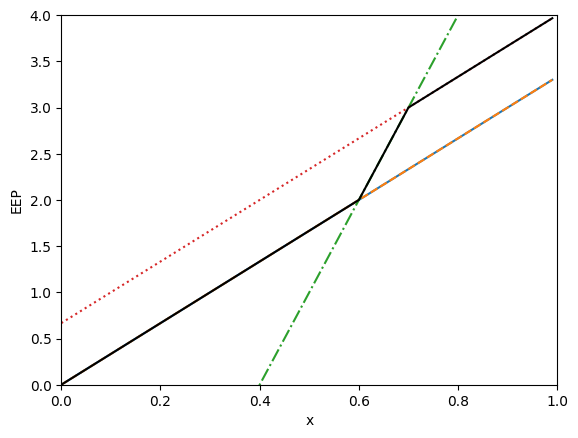

In [5]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [45]:
low_log_z, high_log_z = -2.8, -1.4
low_y, high_y = 0.225, 0.315
low_mass, high_mass = 0.75, 2.25
low_a, high_a = 1.4, 2.6

def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return jnp.log10(z / hydrogen(y, z)) - log_zx_sun

def heavy_elements(y, mh):
    return (1 - y) / (10**-(mh + log_zx_sun) + 1)

def mean_helium_z(z, y0, dydz):
    return y0 + dydz * z

def mean_helium_mh(mh, y0, dydz):
    f = dydz / (10**-(mh + log_zx_sun) + 1)
    return (y0 + f) / (1 + f)

def mean_a_mlt(mass, a1, dadm):
    return a1 + dadm * (mass - 1)

def hierarchical_model(num_stars, lum_obs=None, teff_obs=None, mh_obs=None, 
                       sigma_lum=0.02, sigma_teff=50.0, sigma_mh=0.05):
    
    dydz = numpyro.sample("DY_DZ", TruncatedNormal(1.5, 1.0, low=0.0, high=2.5))
    y0 = numpyro.sample("Y_0", Normal(0.247, 0.001))
    sigma_y = numpyro.sample("sigma_Y", LogNormal(jnp.log(0.01), 0.5))
    
    dadm = numpyro.sample("Da_Dm", TruncatedNormal(-0.3, 0.3, low=-0.5, high=0.0))
    a1 = numpyro.sample("a_1", Normal(2.0, 0.1))
    sigma_a = numpyro.sample("sigma_a", LogNormal(jnp.log(0.1), 0.5))
    
    with numpyro.plate("star", num_stars):
        x = numpyro.sample("x", Uniform(0.01, 0.99))
        eep = numpyro.deterministic("EEP", evol_phase(x))

        mass = numpyro.sample("mass", Salpeter(2.35, low=low_mass, high=high_mass))
        
        if mh_obs is None:
            mh = numpyro.sample("M_H", Uniform(-0.9, 0.5))
        else:
            mh = numpyro.sample("M_H", TruncatedNormal(mh_obs, sigma_mh, low=-0.9, high=0.5))

#         log_z = numpyro.sample("log_Z", Uniform(low_log_z, high_log_z))
#         z = numpyro.deterministic("Z", 10**log_z)
#         mu_y = mean_helium_z(z, y0, dydz)
        
        mu_y = mean_helium_mh(mh, y0, dydz)
        low = (low_y - mu_y) / sigma_y
        high = (high_y - mu_y) / sigma_y
        y_sca = numpyro.sample("Y_scaled", TruncatedNormal(0, 1, low=low, high=high))
#         y = numpyro.sample("Y", TruncatedNormal(mu_y, sigma_y, low=low_y, high=high_y))
        y = numpyro.deterministic("Y", mu_y + sigma_y * y_sca)

        z = numpyro.deterministic("Z", heavy_elements(y, mh))
        log_z = numpyro.deterministic("log_Z", jnp.log10(z))

        mu_a = mean_a_mlt(mass, a1, dadm)
        # when precision issue encountered, this just doesn't truncate!
        
        low = (low_a - mu_a) / sigma_a
        high = (high_a - mu_a) / sigma_a
        a_sca = numpyro.sample("a_scaled", TruncatedNormal(0, 1, low=low, high=high))
#         a_mlt = numpyro.sample("a_MLT", TruncatedNormal(mu_a, sigma_a, low=low_a, high=high_a))
        a_mlt = numpyro.deterministic("a_MLT", mu_a + sigma_a * a_sca)

    xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
    yy = emulator(xx)

    log_lum = log_luminosity(yy[:, 1], yy[:, 2])
    lum = numpyro.deterministic("lum", 10**log_lum)
    teff = numpyro.deterministic("Teff", 10**yy[:, 1])

#     numpyro.sample("lum_obs", Normal(lum, sigma_lum), obs=lum_obs)
#     numpyro.sample("Teff_obs", Normal(teff, sigma_teff), obs=teff_obs)
    
    numpyro.sample("lum_obs", StudentT(10, lum, sigma_lum), obs=lum_obs)
    numpyro.sample("Teff_obs", StudentT(10, teff, sigma_teff), obs=teff_obs)
#     numpyro.sample("M_H", TruncatedNormal(metallicity(y, z), sigma_mh, low=-0.9, high=0.5), obs=mh)

    log_age = numpyro.deterministic("log_age", yy[:, 0])
    age = numpyro.deterministic("age", 10**log_age)

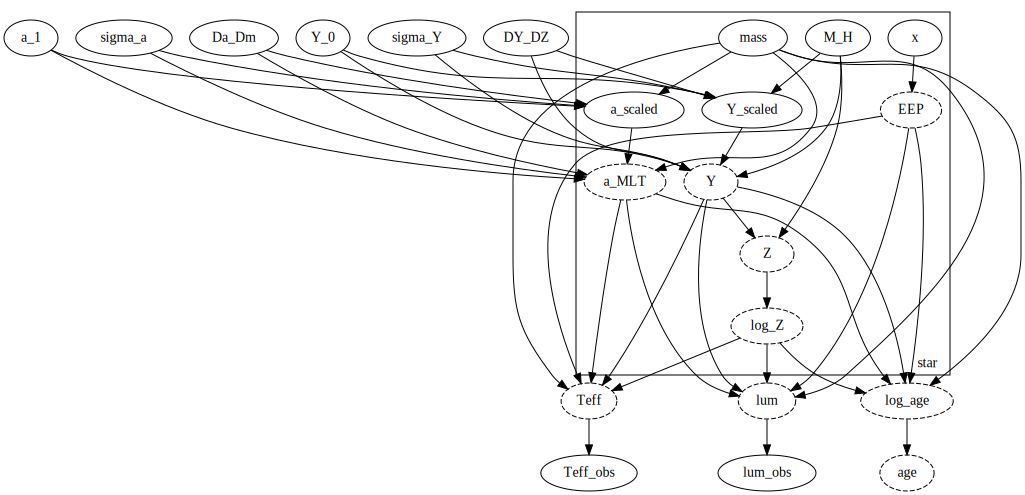

In [112]:
numpyro.render_model(hierarchical_model, model_args=(num_stars,))

In [46]:
rng, key = random.split(rng)
prior_predictive = Predictive(hierarchical_model, num_samples=10000)
prior_samples = prior_predictive(key, 1)

In [89]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

In [9]:
truths = {
    "DY_DZ": 1.5,
    "Y_0": 0.247,
    "sigma_Y": 0.01,
}

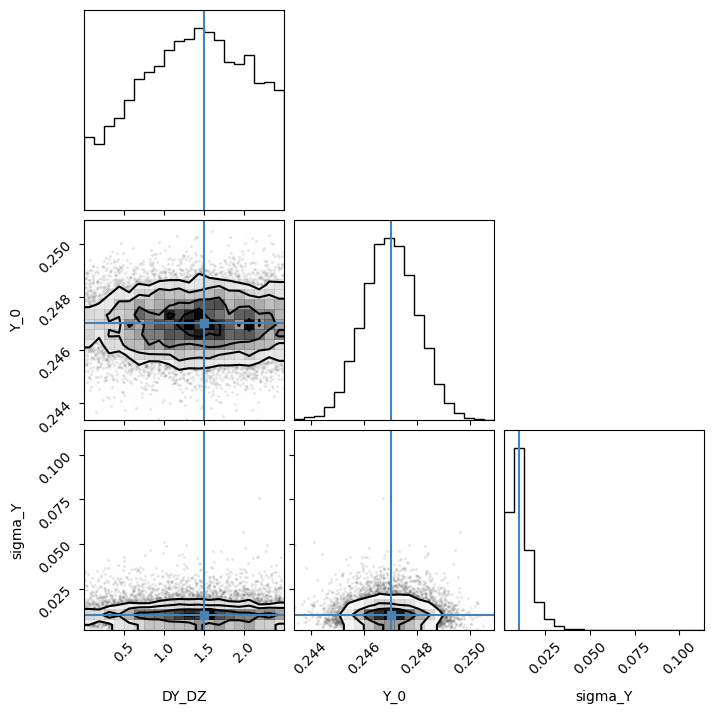

In [10]:
fig = corner(data, group="prior", var_names=["DY_DZ", "Y_0", "sigma_Y"], truths=truths)

In [11]:
truths.update({
    "Da_Dm": -0.3,
    "a_1": 2.0,
    "sigma_a": 0.1
})

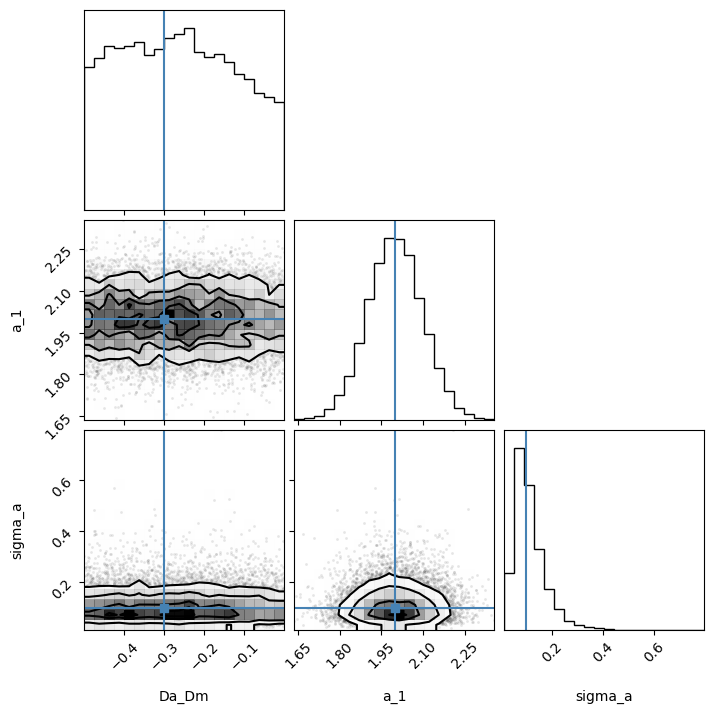

In [12]:
fig = corner(data, group="prior", var_names=["Da_Dm", "a_1", "sigma_a"], truths=truths)

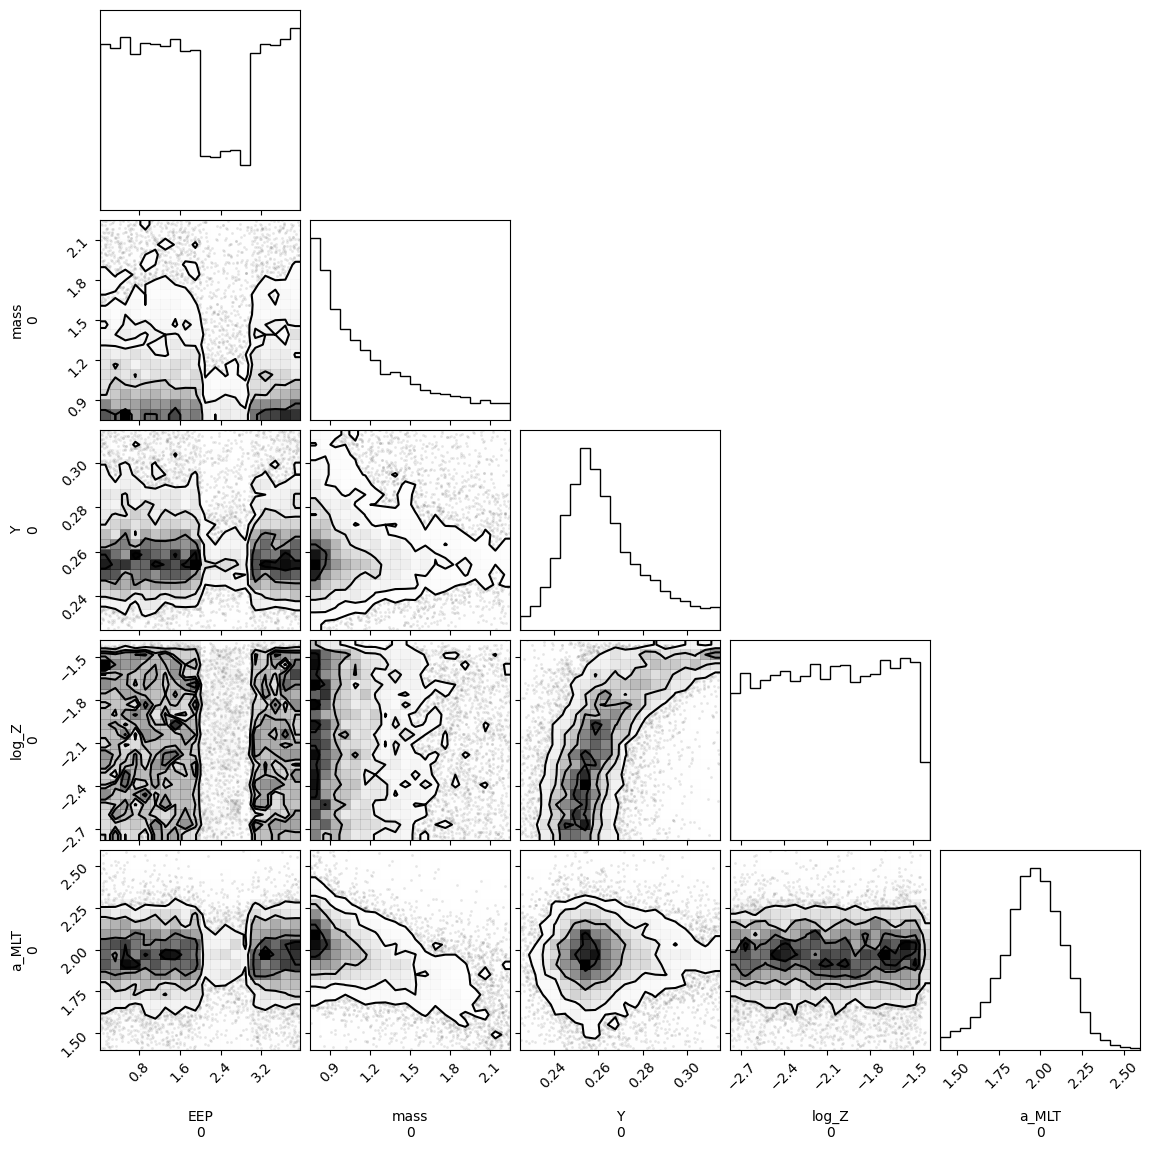

In [13]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "log_Z", "a_MLT"])

In [14]:
import matplotlib.colors as mcolors

In [87]:
num_stars = 30

rng, key = random.split(rng)
true_model = numpyro.handlers.substitute(
    hierarchical_model,
    data=truths,
)

true_predictive = Predictive(true_model, num_samples=1, batch_ndims=0)
true_stars = {
    key: value.squeeze() for key, value in true_predictive(key, num_stars).items()
}

In [88]:
true_stars

{'DY_DZ': Array(1.5, dtype=float64, weak_type=True),
 'Da_Dm': Array(-0.3, dtype=float64, weak_type=True),
 'EEP': Array([1.64111282, 0.81495846, 1.21139443, 0.37991262, 3.62382378,
        2.0130021 , 3.36052519, 1.68485373, 2.28692422, 0.13115882,
        1.45639454, 3.29619542, 1.37751734, 0.63345102, 0.32787479,
        1.92722404, 1.70996427, 1.25735912, 3.45310668, 0.72255765,
        0.5696026 , 2.46859495, 1.53637437, 3.62719405, 1.60203574,
        1.31092006, 0.73283074, 1.79149432, 0.43638805, 0.81724725],      dtype=float64),
 'M_H': Array([-0.2796881 , -0.41393372, -0.27889972, -0.54944614, -0.52585208,
        -0.60462738,  0.33945772,  0.18738587, -0.45384588,  0.09441209,
        -0.52102875,  0.43784014,  0.25074014, -0.43736533,  0.38948244,
         0.29203604, -0.74048121, -0.46327948,  0.06702773,  0.37952924,
        -0.75818495,  0.03608047, -0.56114486, -0.46663194,  0.06814417,
        -0.85352146, -0.66122385, -0.64994986, -0.41204631,  0.29226641],      dtype

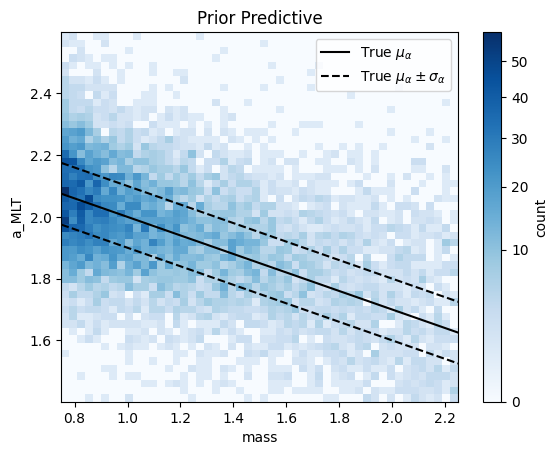

In [17]:
mass = np.linspace(low_mass, high_mass)
mu_a = mean_a_mlt(mass, truths["a_1"], truths["Da_Dm"])

fig, ax = plt.subplots()
*_, im = ax.hist2d(
    data.prior.mass.sel(chain=0).squeeze(), 
    data.prior.a_MLT.sel(chain=0).squeeze(), 
    bins=50, 
#     cmin=1,
    cmap="Blues",
    norm=mcolors.PowerNorm(1/2)
)
# ax.plot(data.prior.mass.sel(chain=0), data.prior.a_MLT.sel(chain=0), ".", zorder=0)

ax.plot(mass, mu_a, "k-", label=r"True $\mu_\alpha$")
ax.plot(mass, mu_a-truths["sigma_a"], "k--", label=r"True $\mu_\alpha\pm\sigma_\alpha$")
ax.plot(mass, mu_a+truths["sigma_a"], "k--")

ax.set_xlabel("mass")
ax.set_ylabel("a_MLT")

fig.colorbar(im, label="count")
ax.legend()
ax.set_title("Prior Predictive");

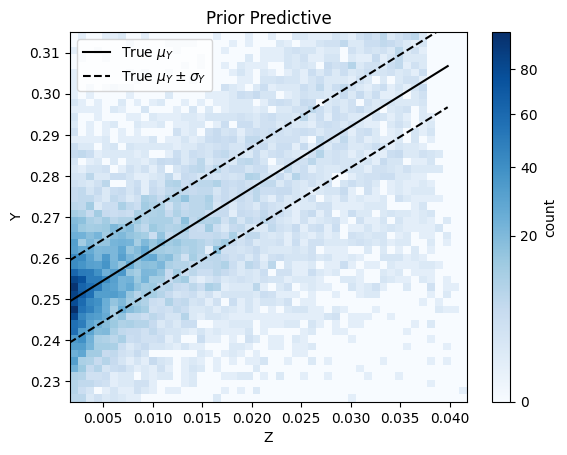

In [18]:
z = np.logspace(low_log_z, high_log_z)
mu_y = mean_helium_z(z, truths["Y_0"], truths["DY_DZ"])

fig, ax = plt.subplots()
*_, im = ax.hist2d(
    data.prior.Z.sel(chain=0).squeeze(), 
    data.prior.Y.sel(chain=0).squeeze(), 
    bins=50, 
#     cmin=1,
    cmap="Blues",
    norm=mcolors.PowerNorm(1/2)
)
# ax.plot(data.prior.Z.sel(chain=0), data.prior.Y.sel(chain=0), ".")
ax.plot(z, mu_y, "k-", label=r"True $\mu_Y$")
ax.plot(z, mu_y-truths["sigma_Y"], "k--", label=r"True $\mu_Y\pm\sigma_Y$")
ax.plot(z, mu_y+truths["sigma_Y"], "k--")

ax.set_xlabel("Z")
ax.set_ylabel("Y")

fig.colorbar(im, label="count")

ax.legend()
ax.set_title("Prior Predictive");

In [19]:
from jax.scipy.special import ndtri, ndtr, log_ndtr

In [20]:
def truncnorm_cdf(x, loc=0, scale=1, low=-float("inf"), high=float("inf")):
    alpha = (low - loc) / scale
    beta = (high - loc) / scale
    phi_alpha = ndtr(alpha)
    z = ndtr(beta) - phi_alpha
    
    eta = (x - loc) / scale
    return (ndtr(eta) - phi_alpha) / z

def truncnorm_icdf(y, loc=0, scale=1, low=-float("inf"), high=float("inf")):
    alpha = (low - loc) / scale
    beta = (high - loc) / scale
    phi_alpha = ndtr(alpha)
    z = ndtr(beta) - phi_alpha
    return loc + scale * ndtri(z * y + phi_alpha)

As the distribution gets further from the truncated region, we reach precision limits.

We need a better solution for this.

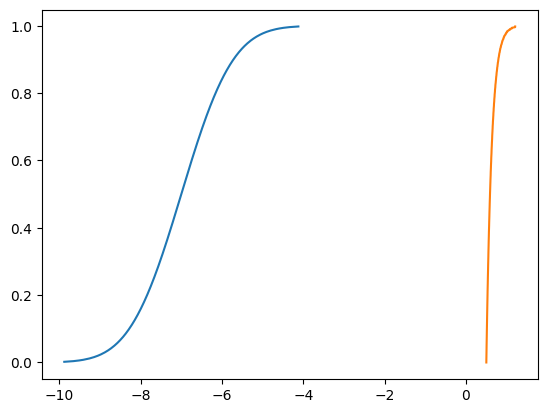

In [21]:
loc = -7
scale = 1

y = np.linspace(0, 1, 501)
x = truncnorm_icdf(y, loc=loc, scale=scale, low=0.5, high=1.5)
plt.plot(loc + scale * ndtri(y), y)
plt.plot(x, y)

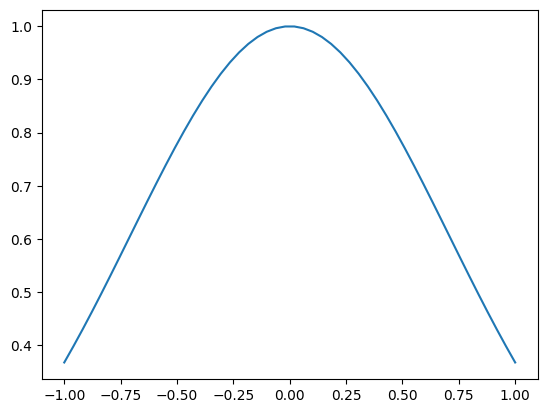

In [22]:
x = np.linspace(-1, 1)
plt.plot(x, np.exp(-x**2))

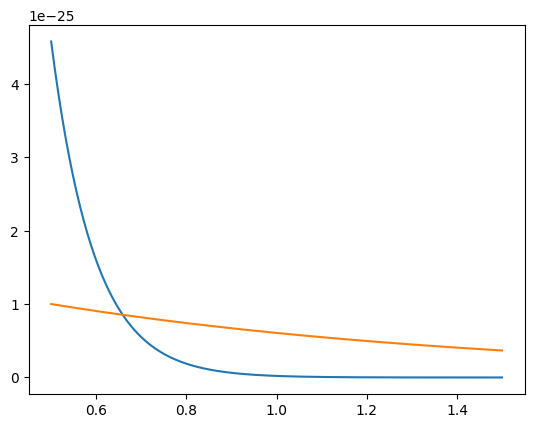

In [23]:
x = np.linspace(0.5, 1.5, 501)
plt.plot(x, jax.scipy.stats.norm.pdf(x, loc=-10))
plt.plot(x, 1e-25*np.exp(-x+0.5))

Just scales the whole thing. Just need to make sure draw from 0 to 1

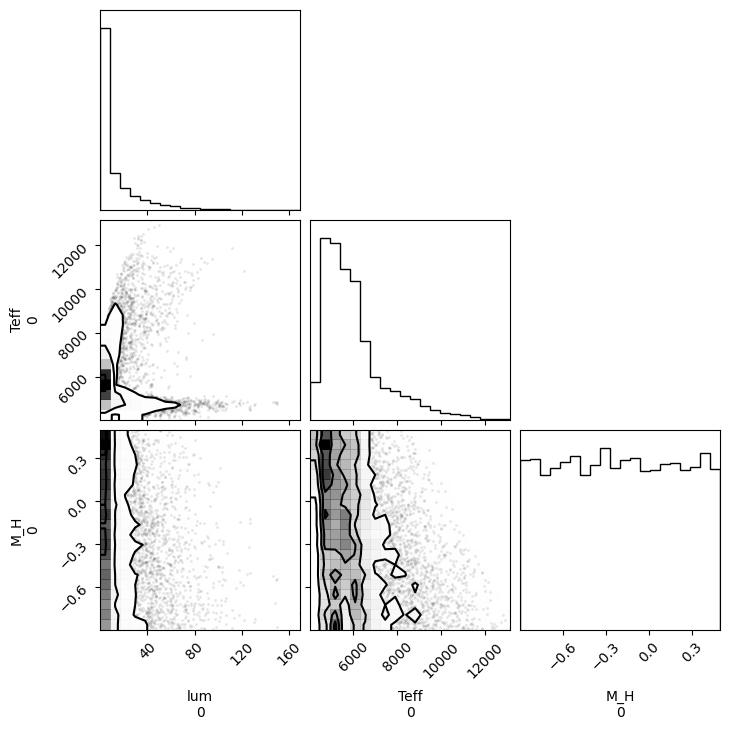

In [24]:
fig = corner(data, group="prior", var_names=["lum", "Teff", "M_H"])

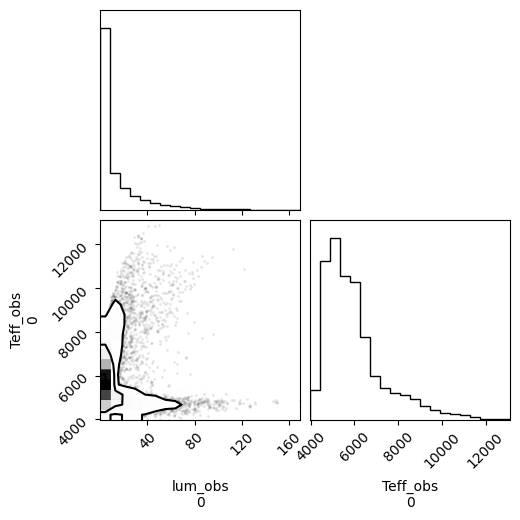

In [25]:
fig = corner(data, group="prior", var_names=["lum_obs", "Teff_obs"])

In [26]:
lum, sigma_lum = 1., 0.03
teff, sigma_teff = 5772.0, 75.
mh, sigma_mh = 0.0, 0.1

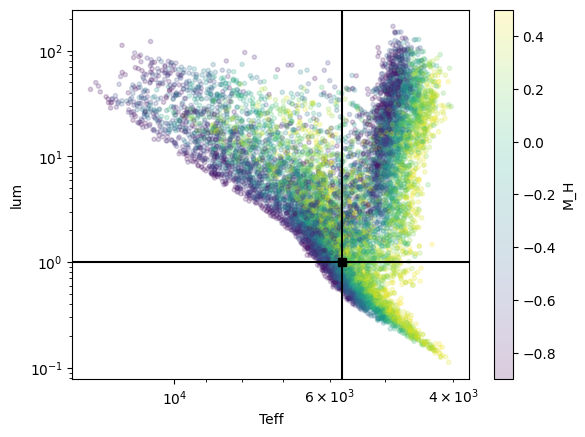

In [27]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "M_H"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

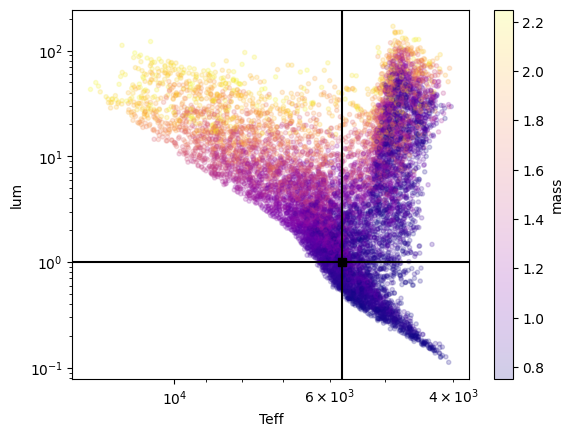

In [28]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

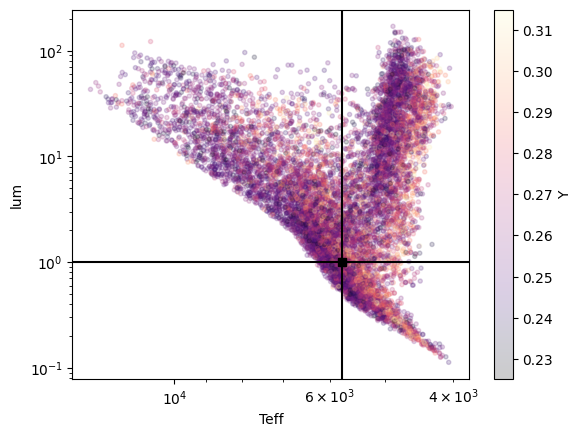

In [29]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

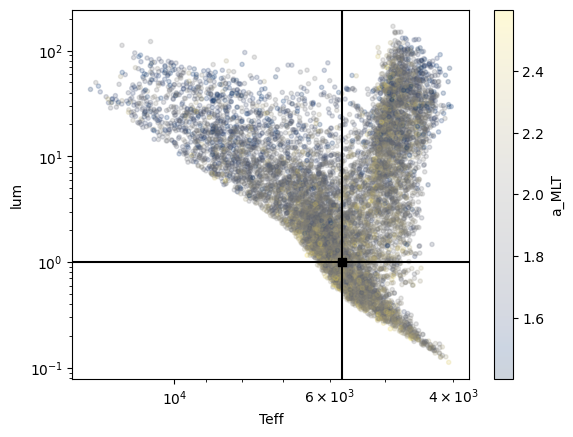

In [30]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

In [31]:
# num_stars = 10

# lum = data.prior.lum.squeeze()[:num_stars].to_numpy()
# teff = data.prior.Teff.squeeze()[:num_stars].to_numpy()
# mh = data.prior.M_H.squeeze()[:num_stars].to_numpy()

# sigma_lum = 0.03 * lum
# sigma_teff = 50.0
# sigma_mh = 0.05

# rng, *keys = random.split(rng, 4)

# lum_obs = lum + sigma_lum * random.normal(keys[0], shape=(num_stars,))
# teff_obs = teff + sigma_teff * random.normal(keys[1], shape=(num_stars,))
# mh_obs = mh + sigma_mh * random.normal(keys[2], shape=(num_stars,))

In [90]:
sigma_lum = 0.03 * true_stars["lum"]
sigma_teff = 50.0
sigma_mh = 0.05

rng, *keys = random.split(rng, 4)

lum_obs = true_stars["lum"] + sigma_lum * random.normal(keys[0], shape=(num_stars,))
teff_obs = true_stars["Teff"] + sigma_teff * random.normal(keys[1], shape=(num_stars,))
mh_obs = true_stars["M_H"] + sigma_mh * random.normal(keys[2], shape=(num_stars,))

In [91]:
nuts = NUTS(hierarchical_model, init_strategy=numpyro.infer.init_to_median,
#             dense_mass=[("M_H", "a_MLT")],  # huge degenerecy between these
#             dense_mass=True  # helps a lot
            )
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [92]:
rng, key = random.split(rng)
mcmc.run(key, num_stars, lum_obs=lum_obs, teff_obs=teff_obs, mh_obs=mh_obs,
         sigma_lum=sigma_lum, sigma_teff=sigma_teff, sigma_mh=sigma_mh)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [93]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       DY_DZ      1.39      0.61      1.42      0.54      2.50    855.17      1.02
       Da_Dm     -0.26      0.13     -0.26     -0.46     -0.04    704.13      1.02
      M_H[0]     -0.32      0.05     -0.32     -0.40     -0.24   4634.53      1.00
      M_H[1]     -0.39      0.05     -0.39     -0.47     -0.31   5728.59      1.00
      M_H[2]     -0.26      0.05     -0.26     -0.34     -0.18   3560.34      1.00
      M_H[3]     -0.56      0.05     -0.56     -0.64     -0.48   4555.20      1.00
      M_H[4]     -0.38      0.06     -0.39     -0.48     -0.29     21.23      1.16
      M_H[5]     -0.53      0.05     -0.53     -0.61     -0.45   5265.27      1.00
      M_H[6]      0.39      0.05      0.39      0.32      0.47   4452.40      1.00
      M_H[7]      0.28      0.05      0.28      0.20      0.36   5194.29      1.00
      M_H[8]     -0.40      0.05     -0.40     -0.48     -0.32   4431.46      1.00
   

In [94]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [95]:
rng, key = random.split(rng)
post_predictive = Predictive(hierarchical_model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, num_stars, mh_obs=mh_obs, sigma_mh=sigma_mh)

In [96]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

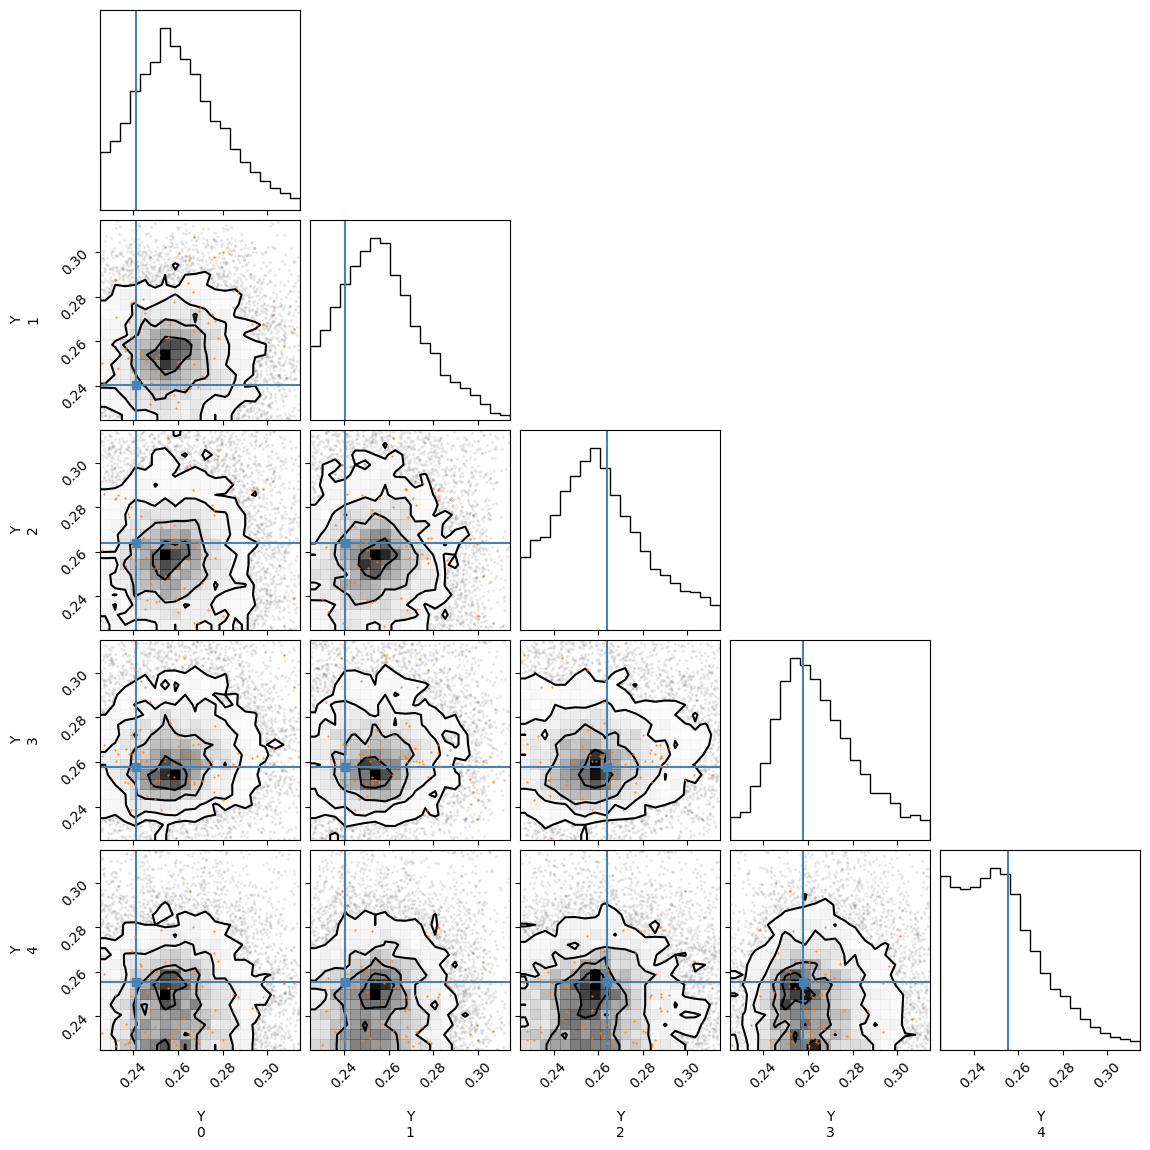

In [97]:
num_plot = 5
name = "Y"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

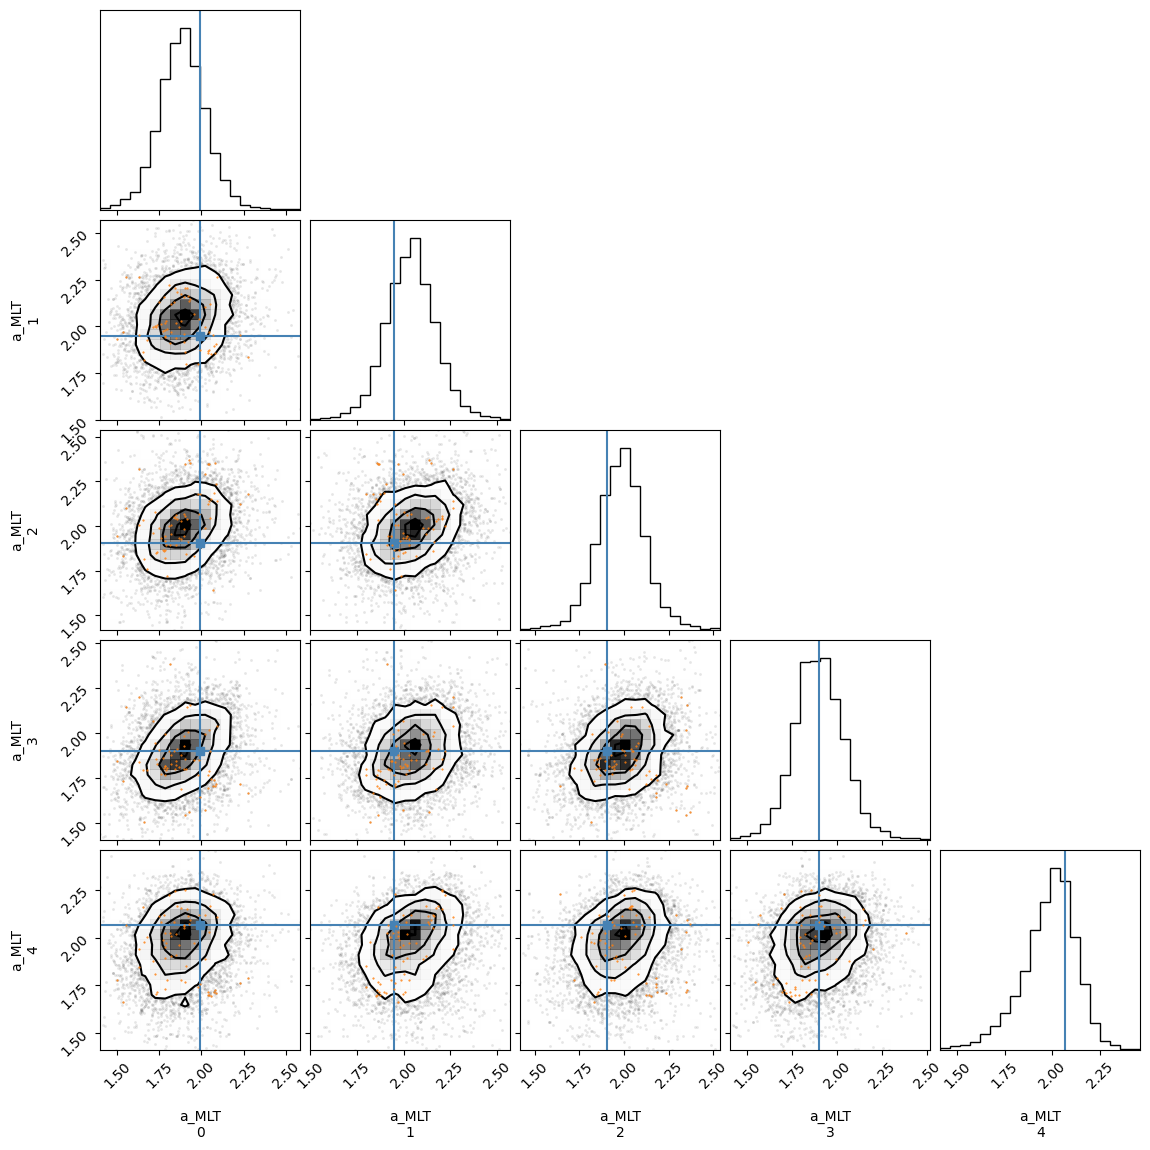

In [98]:
name = "a_MLT"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

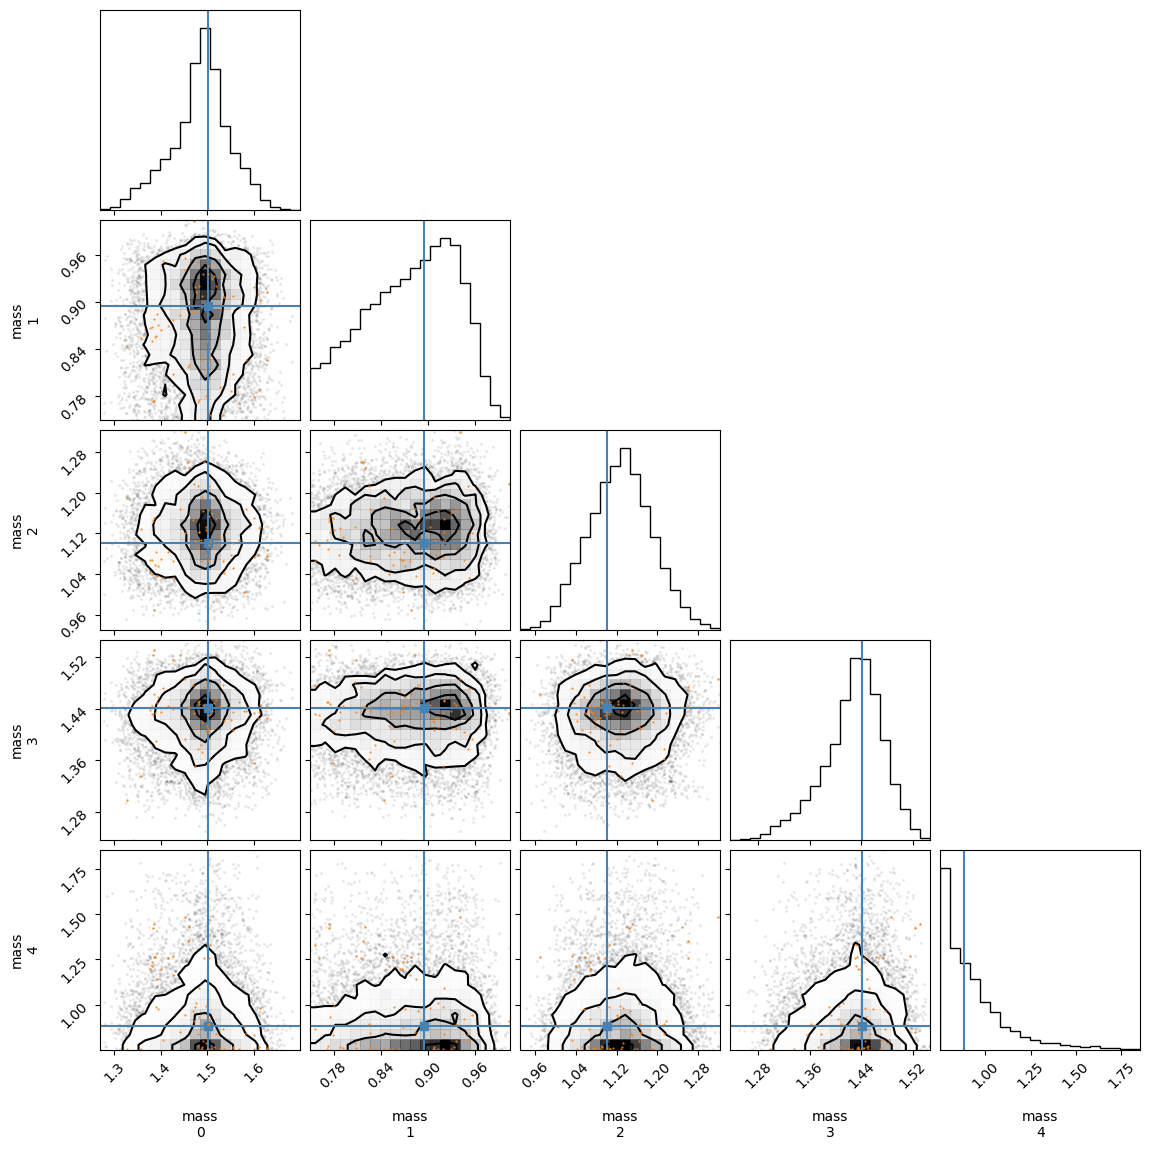

In [99]:
name = "mass"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

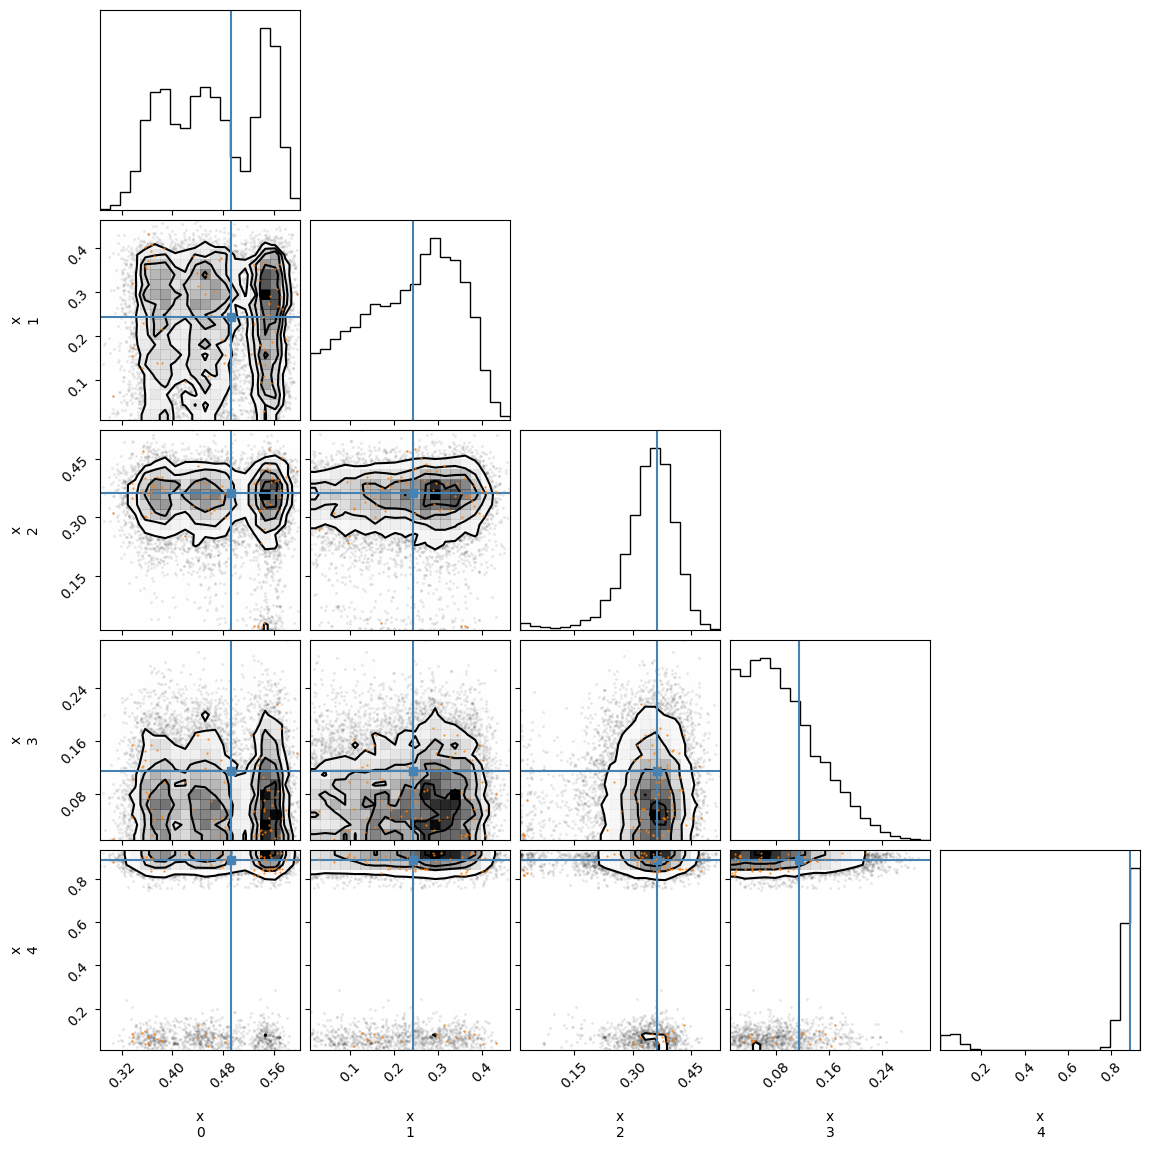

In [100]:
name = "x"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

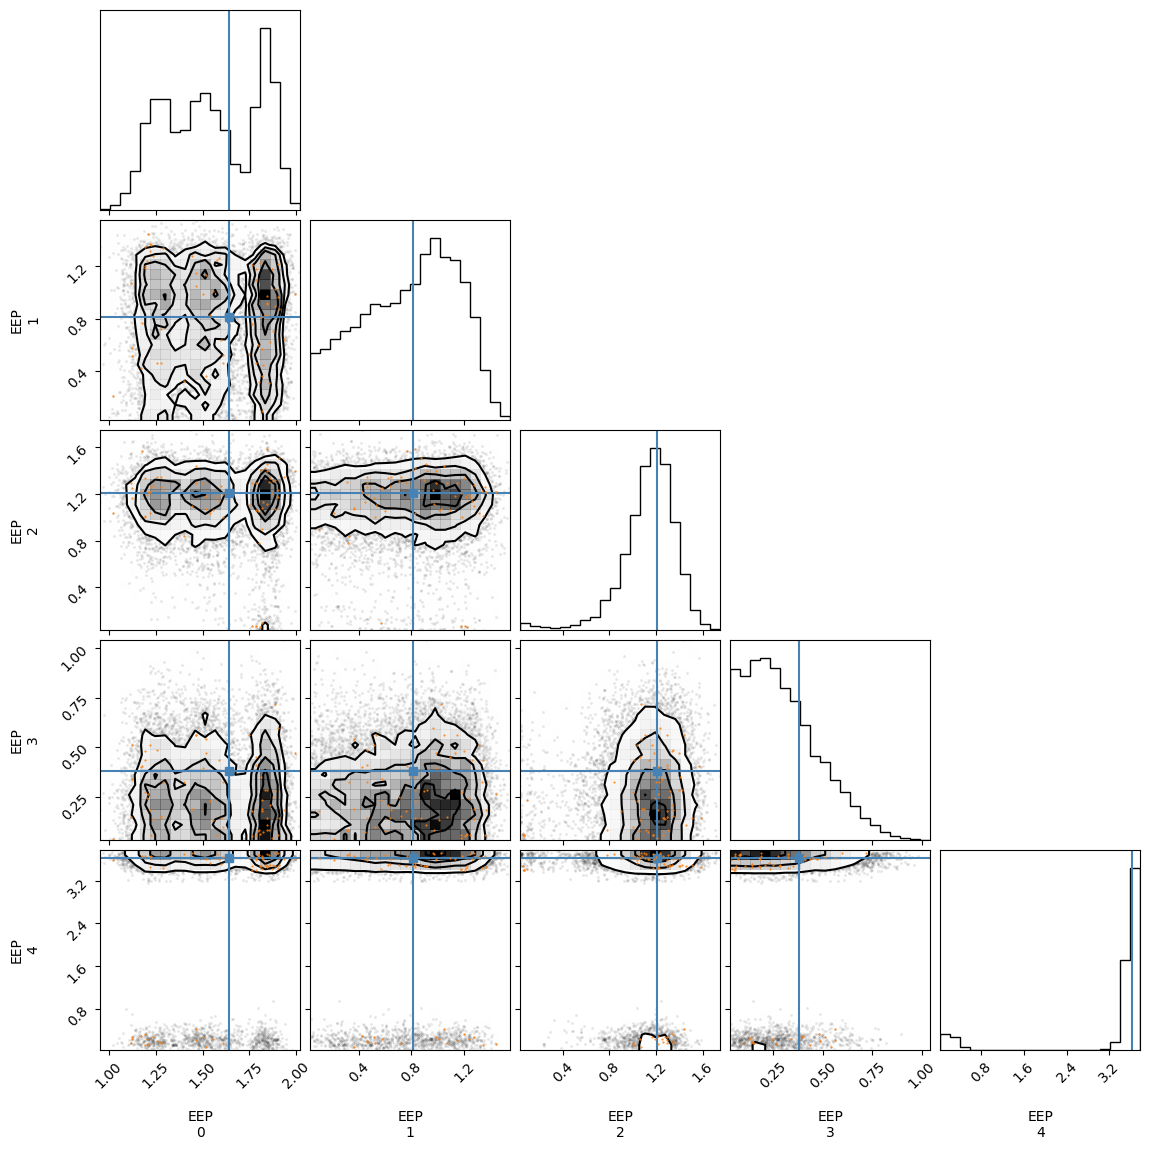

In [101]:
name = "EEP"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

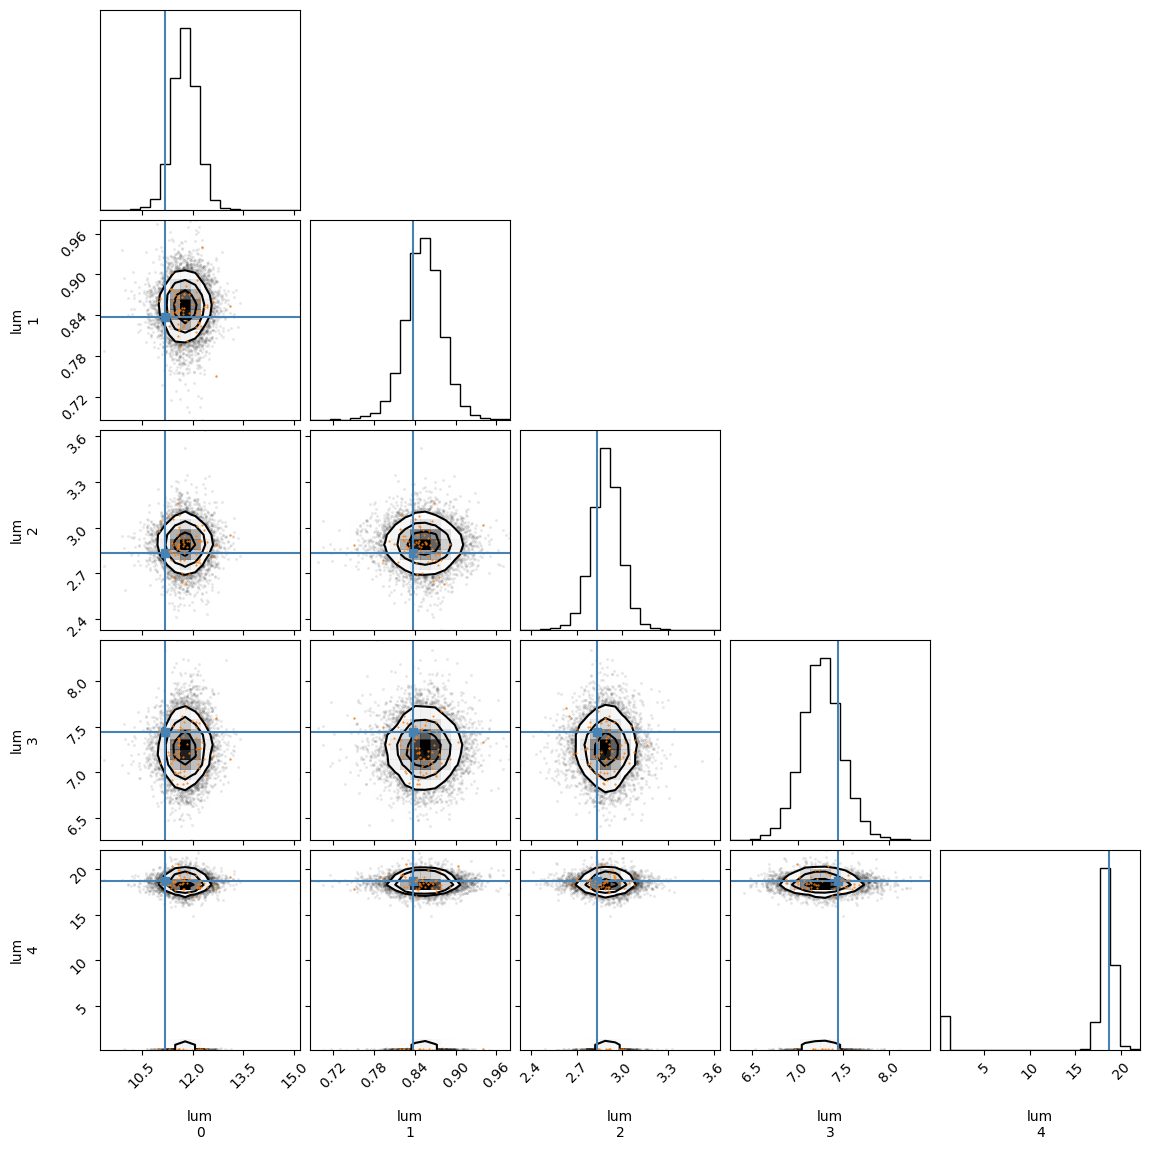

In [102]:
name = "lum"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

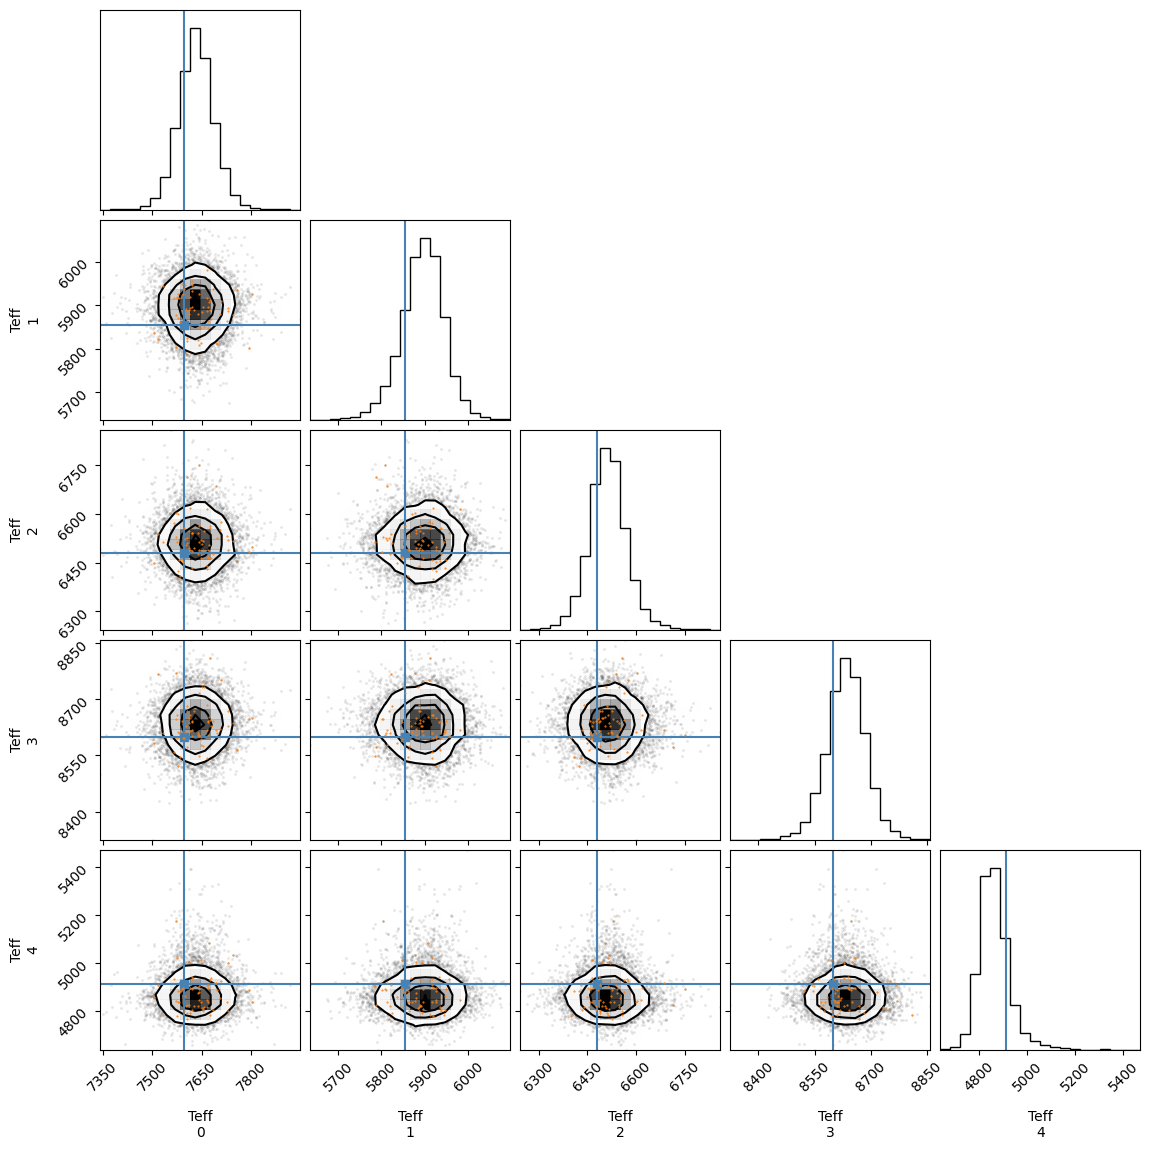

In [103]:
name = "Teff"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

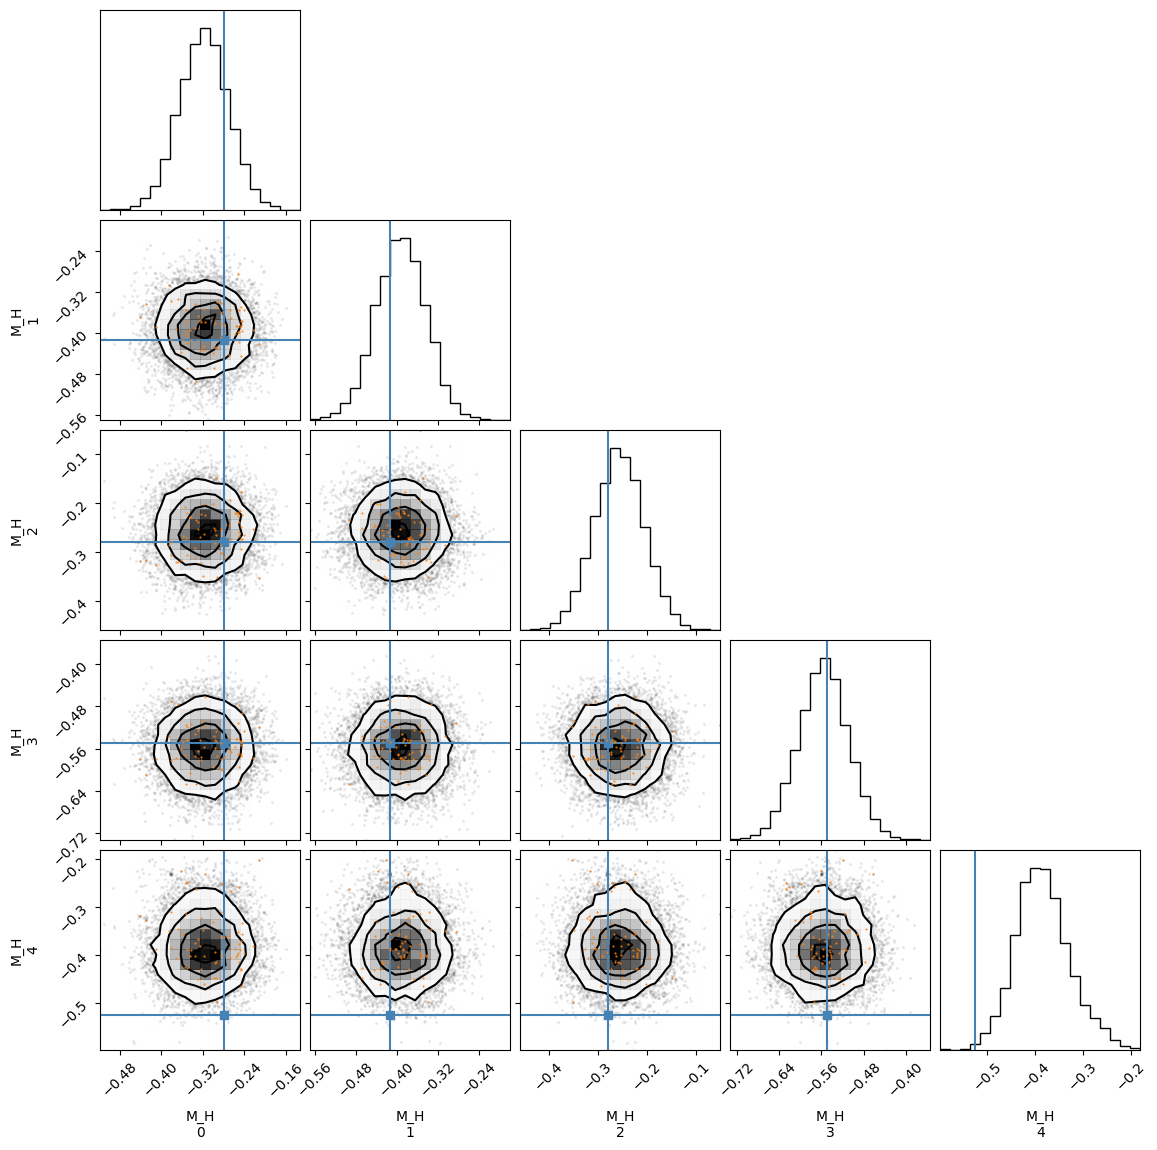

In [104]:
name = "M_H"
coords = {f"{name}_dim_0": list(range(num_plot))}
fig = corner(data, var_names=name, truths=true_stars[name][:num_plot], coords=coords, divergences=True)

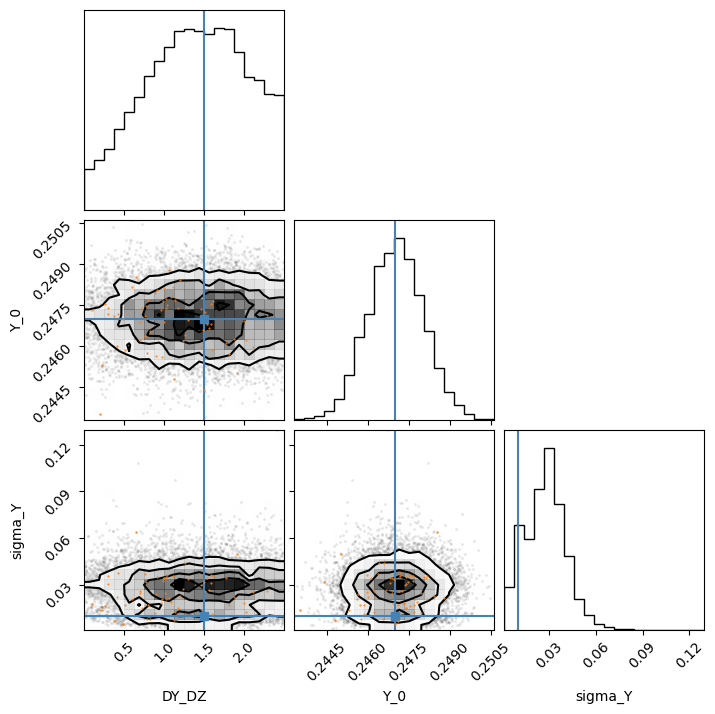

In [105]:
fig = corner(data, group="posterior", var_names=["DY_DZ", "Y_0", "sigma_Y"], truths=truths, divergences=True)

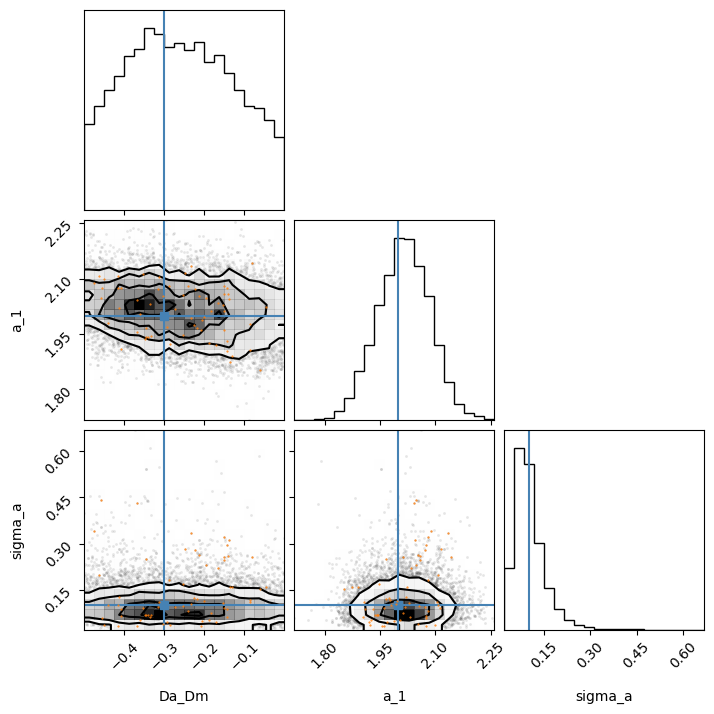

In [106]:
fig = corner(data, group="posterior", var_names=["Da_Dm", "a_1", "sigma_a"], truths=truths, divergences=True)